In [1]:
#Necesssay Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn import model_selection, preprocessing, metrics, svm, ensemble
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier
from sklearn.linear_model import SGDClassifier, ARDRegression, LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
sm=SMOTE(random_state=0)
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from string import punctuation
stuff_to_be_removed = list(stopwords.words("english"))+list(punctuation)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [2]:
#Loading Training Data
train = pd.read_csv('Sentiment Analysis train.csv')
test = pd.read_csv('Sentiment Analysis test.csv')
#sample_sub = pd.read_csv('datasets/sample_submission.csv')

In [3]:
train.isnull().sum()

tweet_id     0
tweet        1
sentiment    0
dtype: int64

In [4]:
train.dropna(inplace=True)

In [5]:
#total_data['sentiment'] = total_data.replace(3.0,'')
#total_data = total_data.drop(total_data[[total_data['sentiment']==3.0]],0)
train = train.drop(train[train['sentiment']==3].index)

In [6]:
#Concation train and test data
total_data = train.append(test,ignore_index = True)
total_data['tweet'] = total_data['tweet'].astype('str')

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [7]:
total_data['sentiment'].value_counts()

1.0    4310
2.0    2382
0.0     456
Name: sentiment, dtype: int64

In [8]:
# Text Cleaning
tok = WordPunctTokenizer()
lemma = WordNetLemmatizer()
# patterns to remove html tags numbers and special Characters
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
shortcuts = {'u': 'you', 'y': 'why', 'r': 'are', 'doin': 'doing', 'hw': 'how', 'k': 'okay', 'm': 'am', 'b4': 'before',
            'idc': "i do not care", 'ty': 'thankyou', 'wlcm': 'welcome', 'bc': 'because', '<3': 'love', 'xoxo': 'love',
            'ttyl': 'talk to you later', 'gr8': 'great', 'bday': 'birthday', 'awsm': 'awesome', 'gud': 'good', 'h8': 'hate',
            'lv': 'love', 'dm': 'direct message', 'rt': 'retweet', 'wtf': 'hate', 'idgaf': 'hate',
             'irl': 'in real life', 'yolo': 'you only live once'}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
shortcuts_pattern = re.compile(r'\b(' + '|'.join(shortcuts.keys()) + r')\b')
def clean_text(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)#for removing patterns like #,@ and punctuation
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    shortcuts_handled = shortcuts_pattern.sub(lambda x: shortcuts[x.group()],neg_handled)
    letters_only = re.sub("[^a-zA-Z]", " ", shortcuts_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    lemmated_words = [lemma.lemmatize(word) for word in words]
    return (" ".join( lemmated_words)).strip()

In [9]:
total_data['cleaned_tweets'] = total_data['tweet'].apply(lambda x: clean_text(x))

EDA

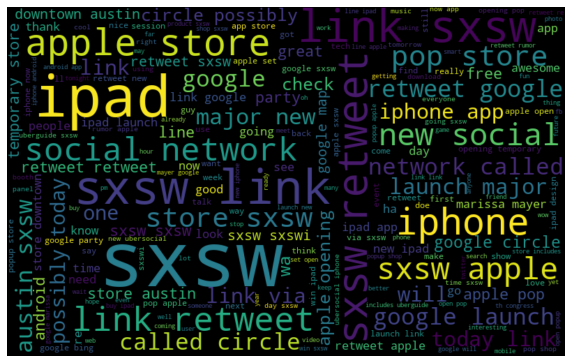

In [10]:
all_words = ' '.join([text for text in total_data['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

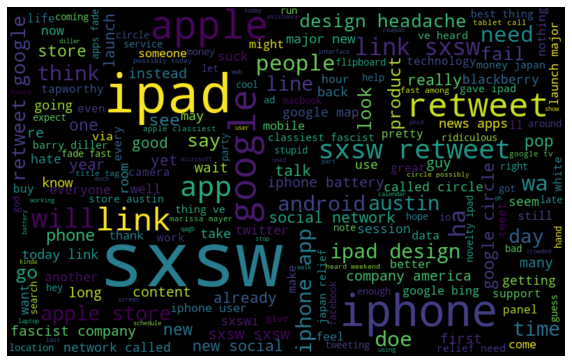

In [11]:
# Words in negative tweets
normal_words =' '.join([text for text in total_data['cleaned_tweets'][total_data['sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

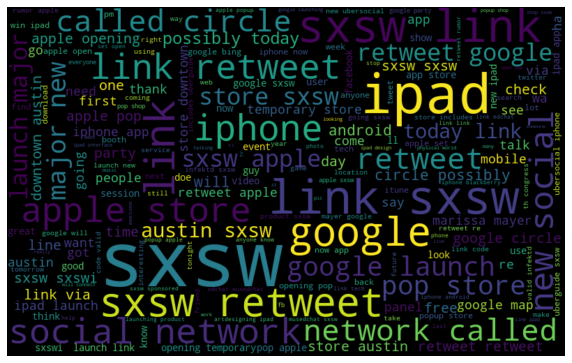

In [12]:
# Words in neutral tweets
negative_words = ' '.join([text for text in total_data['cleaned_tweets'][total_data['sentiment'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

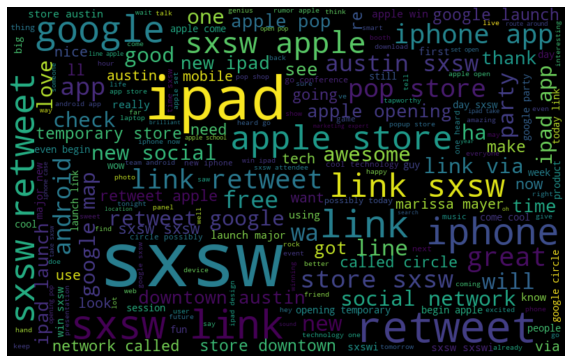

In [13]:
# Words in positive tweets
negative_words = ' '.join([text for text in total_data['cleaned_tweets'][total_data['sentiment'] == 2]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
# Words in can't say tweets
#negative_words = ' '.join([text for text in total_data['cleaned_tweets'][total_data['sentiment'] == 3]])
#wordcloud = WordCloud(width=800, height=500,
#random_state=21, max_font_size=110).generate(negative_words)
#plt.figure(figsize=(10, 7))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis('off')
#plt.show()

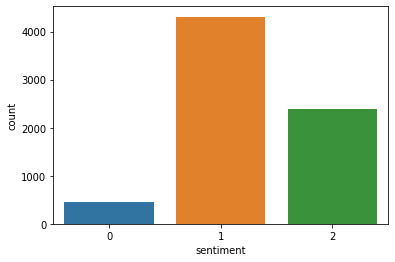

In [15]:
sns.countplot(train["sentiment"])

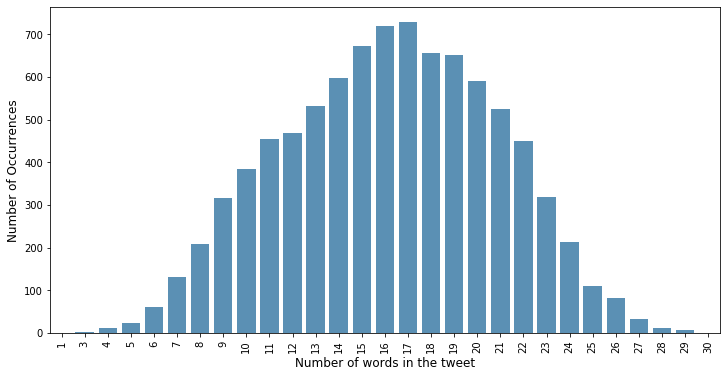

In [16]:
color = sns.color_palette()
total_data['no_of_words'] = total_data['cleaned_tweets'].apply(lambda x :len(x.split(' ')))
cnt_words=total_data['no_of_words'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_words.index, cnt_words.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the tweet', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Model

In [17]:
train_data = total_data[total_data['sentiment'].isnull() != True]
test_data = total_data[total_data['sentiment'].isnull() == True]

In [18]:
#Linear_svm Model
params = {'tfidf__max_df': [0.9, 0.95],'tfidf__ngram_range': [(1,1), (1,2), (1,3)], "svc__C": [0.001,.01, .1, 1, 10, 100]}

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ("svc",LogisticRegression()),
    #("svc", LogisticRegression(penalty='l2',dual=False,random_state=0, max_iter=1000,tol=0.01, class_weight={0:7,1:1,2:2})),
    #("svc", LinearSVC(penalty='l2',dual=False,random_state=0, max_iter=1000,tol=0.01, class_weight={0:7,1:1,2:2})), ,
])
gs = GridSearchCV(pipeline, params,cv=10, verbose=2, n_jobs=-1)
gs.fit(train_data['cleaned_tweets'], train_data['sentiment'])
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scal

In [19]:
predicted = gs.predict(test_data['cleaned_tweets'])

In [20]:
sub_df = pd.DataFrame(columns=['tweet_id', 'sentiment'])
sub_df['tweet_id'] = test['tweet_id']
sub_df['sentiment'] = predicted
sub_df.to_csv('test_prediction_svm.csv', index=False)

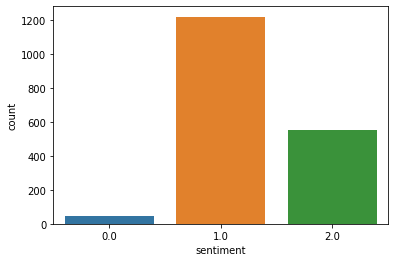

In [21]:
sns.countplot(sub_df["sentiment"])